In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow import keras
from tensorflow.keras import Model, Input, optimizers

from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



In [2]:
import os
print(os.listdir("./cell-images/cell_images"))

['Parasitized', 'Uninfected']


In [3]:
infected = os.listdir('./cell-images/cell_images/Parasitized/') 
uninfected = os.listdir('./cell-images/cell_images/Uninfected/')

In [4]:
#retrieving the images and storing them in the arrays
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("./cell-images/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        
        data.append(np.array(resize_img))
        
        labels.append(1)
        
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread("./cell-images/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        
        data.append(np.array(resize_img))
        
        labels.append(0)
        
    except AttributeError:
        print('')

In [5]:
cells = np.array(data)
labels = np.array(labels)
cells.shape,labels.shape

((27558, 64, 64, 3), (27558,))

In [6]:
#Shuffle the data
cells,labels = shuffle(cells,labels)


In [7]:
cells = cells.astype("float32")/255
labels = tf.keras.utils.to_categorical(labels)


In [8]:
x_train,x_test,y_train,y_test = train_test_split(cells,labels,test_size=0.33,random_state=45)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((18463, 64, 64, 3), (9095, 64, 64, 3), (18463, 2), (9095, 2))

In [9]:
input_tensor = Input(shape=x_train.shape[1:])

mobilenet_model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Administrator\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 1s 0us/step


In [10]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

In [11]:
last = mobilenet_model.output
x = Flatten()(last)
preds = Dense(2, activation='softmax')(x)

tuned_mobilenet_model = Model(mobilenet_model.input, preds)

In [12]:
tuned_mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

In [16]:
tuned_mobilenet_model.compile(optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = tuned_mobilenet_model.fit(x_train, y_train, batch_size=64, epochs=8, validation_split=0.15)

Train on 15693 samples, validate on 2770 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/8
15693/15693 [==============================] - 785s 50ms/sample - loss: 0.2694 - acc: 0.9260 - val_loss: 0.1924 - val_acc: 0.9570
Epoch 2/8
15693/15693 [==============================] - 459s 29ms/sample - loss: 0.1155 - acc: 0.9615 - val_loss: 0.1463 - val_acc: 0.9610
Epoch 3/8
15693/15693 [==============================] - 458s 29ms/sample - loss: 0.0961 - acc: 0.9672 - val_loss: 0.2091 - val_acc: 0.9408
Epoch 4/8
15693/15693 [==============================] - 605s 39ms/sample - loss: 0.1000 - acc: 0.9668 - val_loss: 0.1826 - val_acc: 0.9433
Epoch 5/8
15693/15693 [==============================] - 458s 29ms/sample - loss: 0.0701 - acc: 0.9751 - val_loss: 0.1197 - val_acc: 0.9639
Epoch 6/8
15693/15693 [==============================] - 458s 29ms/sample - loss: 0.0571 - acc: 0.9802 - val_loss: 0.1547 - val_acc: 0.9625
Epoch 7/8
15693/15693 [==============================] - 422s 2

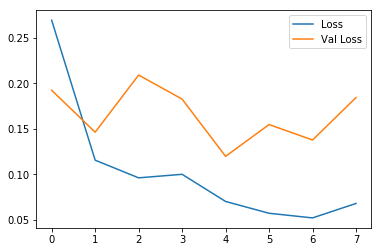

In [18]:
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label="Val Loss")
plt.legend()

In [20]:
accuracy  = tuned_mobilenet_model.evaluate(x_test,y_test)
print("Test Accuracy:-",accuracy)

9095/9095 [==============================] - 29s 3ms/sample - loss: 0.1759 - acc: 0.9481
Test Accuracy:- [0.17585220225175832, 0.94810337]
